# KLASIFIKASI BERITA HOAX WITH NAIVE BAYES

In [10]:
import pandas as pd
data = pd.read_csv('dataset_news.csv')

print(data.shape)
data.head()

(4231, 6)


,ID,label,tanggal,judul,narasi,nama file gambar
0,71,1,17-Aug-20,Pemakaian Masker Menyebabkan Penyakit Legionna...,A caller to a radio talk show recently shared ...,71.jpg
1,461,1,17-Jul-20,Instruksi Gubernur Jateng tentang penilangan ...,Yth.Seluruh Anggota Grup Sesuai Instruksi Gube...,461.png
2,495,1,13-Jul-20,Foto Jim Rohn: Jokowi adalah presiden terbaik ...,Jokowi adalah presiden terbaik dlm sejarah ban...,495.png
3,550,1,8-Jul-20,"ini bukan politik, tapi kenyataan Pak Jokowi b...","Maaf Mas2 dan Mbak2, ini bukan politik, tapi k...",550.png
4,681,1,24-Jun-20,Foto Kadrun kalo lihat foto ini panas dingin,Kadrun kalo lihat foto ini panas dingin . .,681.jpg


# Data Preprocessing

In [11]:
pip install sastrawi

Note: you may need to restart the kernel to use updated packages.


In [12]:
x = data['narasi']

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

stopwords = StopWordRemoverFactory().get_stop_words() 
stemmer = StemmerFactory().create_stemmer()

import re 

def text_preprocess(text, stemmer, stopwords):
    x = text.str.replace(r'\W',' ')
    x = x.str.replace(r'\s+',' ')
    x = x.str.lower()
    x = x.apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split() if item not in stopwords]))
    return x

data['processed_text'] = text_preprocess(x, stemmer, stopwords)

In [13]:
data['processed_text']

0       a caller to a radio talk show recently shared ...
1       yth seluruh anggota grup sesuai instruksi gube...
2       jokowi presiden baik dlm sejarah bangsa indone...
3       maaf mas2 mbak2 bukan politik nyata pak jokowi...
4                     kadrun kalo lihat foto panas dingin
                              ...                        
4226      kpk larang bawa brimob senjata masuk gedung dpr
4227    jangan mau alih pakai adat fokus isyarat commu...
4228                           akhir nya kenal bang denny
4229              bapak kesederhaan nipu rakyat indonesia
4230    in nolak kalau mau periksa bukan periksa kepal...
Name: processed_text, Length: 4231, dtype: object

In [14]:
import nltk
nltk.download()

wordfreq = {}
for sentence in data['processed_text']:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

import heapq
most_freq = heapq.nlargest(300, wordfreq, key=wordfreq.get)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [15]:
wordfreq = {token: freq for token, freq in sorted(wordfreq.items(), key=lambda item: item[1], reverse=True)} 
wordfreq

{'yg': 762,
 'jadi': 642,
 'orang': 579,
 'indonesia': 559,
 'sebut': 393,
 'jokowi': 320,
 'laku': 285,
 'anak': 282,
 'semua': 280,
 'nyata': 275,
 'hari': 270,
 'the': 260,
 'virus': 252,
 'buat': 252,
 'baru': 246,
 'satu': 243,
 'negara': 239,
 'corona': 230,
 '19': 217,
 'bukan': 215,
 'china': 215,
 'sama': 212,
 'presiden': 206,
 'islam': 206,
 'covid': 205,
 'info': 205,
 'masuk': 205,
 'tinggal': 202,
 'tahun': 201,
 'apa': 201,
 'foto': 200,
 'berita': 195,
 'jakarta': 195,
 'banyak': 195,
 'jangan': 195,
 '1': 194,
 'kerja': 192,
 'kata': 191,
 'benar': 191,
 'hati': 189,
 'perintah': 188,
 'hoax': 188,
 'nama': 186,
 '2': 181,
 'mau': 178,
 'nya': 177,
 'warga': 171,
 'allah': 169,
 'lalu': 166,
 'lihat': 165,
 'sebar': 165,
 'rumah': 164,
 'atas': 156,
 'lebih': 155,
 'dunia': 153,
 'besar': 153,
 'rakyat': 153,
 'salah': 152,
 'video': 151,
 'polisi': 144,
 'beri': 142,
 'kalau': 141,
 'edar': 140,
 '3': 139,
 'ada': 138,
 'jalan': 138,
 'mulai': 137,
 'tak': 136,
 'guna

In [16]:
import numpy as np  
import random  
import string

sentence_vectors = []
for sentence in data['processed_text']:
    sentence_tokens = nltk.word_tokenize(sentence)
    sent_vec = []
    for token in most_freq:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)

sentence_vectors = np.asarray(sentence_vectors)
print(sentence_vectors)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# TF-IDF

In [17]:
word_idf_values = {}
for token in most_freq:
    doc_containing_word = 0
    for document in data['processed_text']:
        if token in nltk.word_tokenize(document):
            doc_containing_word += 1
    word_idf_values[token] = np.log(len(x)/(1 + doc_containing_word))


word_tf_values = {}
for token in most_freq:
    sent_tf_vector = []
    for document in data['processed_text']:
        doc_freq = 0
        for word in nltk.word_tokenize(document):
            if token == word:
                  doc_freq += 1
        word_tf = doc_freq/len(nltk.word_tokenize(document))
        sent_tf_vector.append(word_tf)
    word_tf_values[token] = sent_tf_vector
    
tfidf_values = []
for token in word_tf_values.keys():
    tfidf_sentences = []
    for tf_sentence in word_tf_values[token]:
        tf_idf_score = tf_sentence * word_idf_values[token]
        tfidf_sentences.append(tf_idf_score)
    tfidf_values.append(tfidf_sentences)

tf_idf_model = np.asarray(tfidf_values)
tf_idf_model = np.transpose(tf_idf_model)

print(tf_idf_model)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Labelling Target

In [18]:
from sklearn.preprocessing import LabelEncoder
le_label = LabelEncoder()

data['label'] = le_label.fit_transform(data['label'])
y = data['label']

In [19]:
y

0       1
1       1
2       1
3       1
4       1
       ..
4226    1
4227    1
4228    1
4229    1
4230    1
Name: label, Length: 4231, dtype: int64

# Modelling Using NaiveBayes

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(sentence_vectors, y, test_size=(0.1))

In [35]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(x_train, y_train)
print('Accuracy - training set: {:.2f}'
     .format(model.score(x_train, y_train)))
print('Accuracy - test set: {:.2f}'
    .format(model.score(x_test, y_test)))

Accuracy - training set: 0.59
Accuracy - test set: 0.52


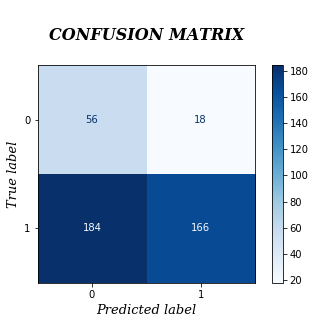

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, plot_confusion_matrix

# plot confusion matriks
plot_confusion_matrix(model, x_test, y_test,
                    cmap=plt.cm.Blues,
                    values_format='.4g')

plt.title('\nCONFUSION MATRIX\n', size=16, weight='bold', style='oblique', family='serif')
plt.ylabel('True label', size=13, weight='medium', style='oblique', family='serif')
plt.xlabel('Predicted label', size=13, weight='medium', style='oblique', family='serif')
plt.show()

In [37]:
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.23      0.76      0.36        74
           1       0.90      0.47      0.62       350

    accuracy                           0.52       424
   macro avg       0.57      0.62      0.49       424
weighted avg       0.79      0.52      0.58       424



# SEKIAN

By: KELOMPOK 1